# Space Based Thermal Instrument Digital Twin
This code simulates infrared spectral observations for space missions, it was specifically designed for the Nightingale proposal
for NASA's New Frontiers (NF5) opportunity. It reads spacecraft configuration from a JSON file and imports a simulated thermal map.

In [52]:
import json
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import Bandpass_Sensor_Calculations

from scipy.spatial.transform import Rotation as R
from scipy.constants import h, c, k

In [53]:
# Load spacecraft configuration from JSON
with open("Nightingale_Configuration.json", "r") as f:
    config = json.load(f)

In [54]:
# Extract parameters from configuration
fov_deg = config["field_of_view"]["horizontal"]
altitude = config["spacecraft_state"]["position"]["altitude"]
lat = config["spacecraft_state"]["position"]["latitude"]
lon = config["spacecraft_state"]["position"]["longitude"]
roll_deg = config["spacecraft_state"]["pointing"]["roll"]
wavenumber_min = config["wavenumber_range"]["min"]
wavenumber_max = config["wavenumber_range"]["max"]
spectral_resolution = config["spectral_resolution"]
nside = 2048 # just a default value for now - must be a power of 2

detector_properties = config['detector_properties']
telescope_properties = config['telescope_properties']
target_body_properties = config['target_body_properties']
integration_properties = config['integration_properties']
absorption = float(config['absorption'])

wavenumber_range = config['wavenumber_range']
bandpasses = config['bandpasses']

for bandpass in bandpasses:
    # Convert bandpass from µm to cm^-1
    lower_in_cm = 1 / (bandpass['lower'] * 1e-4)
    upper_in_cm = 1 / (bandpass['upper'] * 1e-4)

    if lower_in_cm > wavenumber_range['max'] or upper_in_cm < wavenumber_range['min']:
        raise ValueError(f"Bandpass {bandpass} in cm^-1: lower {lower_in_cm}, upper {upper_in_cm} is outside the specified wavenumber range.")

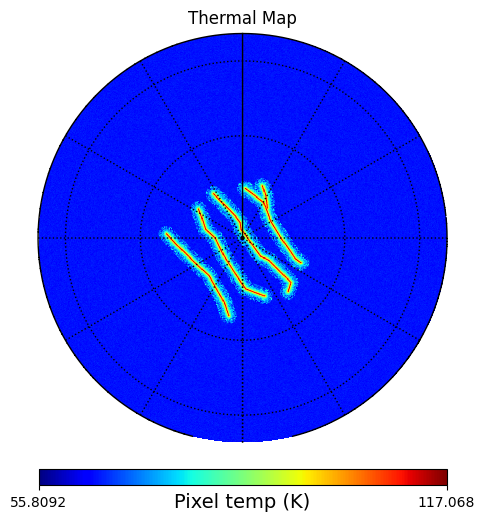

In [55]:
# Read and display thermal map from the FITS file
thermal_map = hp.read_map("fracture_map.fits")

# Display the map with overlaid latitude and longitude lines
# hp.mollview(thermal_map, title="Thermal Map", unit="Pixel temp (K)", hold=True)    
# hp.mollview(thermal_map, title="Thermal Map", unit="Pixel temp (K)", norm="hist", cmap="jet", rot=(0, -90, 0), xsize=1600)
# hp.gnomview(thermal_map, title="Thermal Map", unit="Pixel temp (K)", rot=(0, -90, 0), reso=10, xsize=800, ysize=800, norm="hist", cmap="jet")
hp.orthview(thermal_map, title="Thermal Map", unit="Pixel temp (K)", rot=(0, -90, 0), half_sky=True, norm="linear", cmap="jet")
hp.graticule()
plt.show()

In [56]:
# FUNCTION 
# Identify HEALPix pixels within the spacecraft's field of view (FoV).
# The function accounts for spacecraft pointing and roll. It assumes a square FoV 
# It is only written for a square FoV and uses the approximation that FoV is small and far from s/c.
def pixels_in_fov(lat, lon, fov_deg, roll_deg, nside):
    # Convert latitude, longitude, FoV, and roll to radians
    theta, phi, half_fov_rad, roll_rad = np.radians([90 - lat, lon, fov_deg / 2.0, roll_deg])
    
    # Initialize rotation object for roll angle
    r = R.from_euler('z', roll_rad, degrees=False)
    
    # Initialize list to store pixels within FoV
    fov_pixels = []
    
    # Query pixels within a circular region as candidates for square FoV
    circle_radius = np.sqrt(2) * half_fov_rad
    candidate_pixels = hp.query_disc(nside, hp.ang2vec(theta, phi), circle_radius)
    
    for pixel in candidate_pixels:
        # Get angular coordinates of the candidate pixel
        theta_pixel, phi_pixel = hp.pix2ang(nside, pixel)
        
        # Convert to Cartesian coordinates relative to the spacecraft
        x = np.sin(theta_pixel) * np.cos(phi_pixel) - np.sin(theta) * np.cos(phi)
        y = np.sin(theta_pixel) * np.sin(phi_pixel) - np.sin(theta) * np.sin(phi)
        z = np.cos(theta_pixel) - np.cos(theta)
        
        # Apply roll rotation to the Cartesian coordinates
        rotated_point = r.apply([x, y, z])
        
        # Check if the rotated point falls within the square FoV in Cartesian space
        if np.abs(rotated_point[0]) <= np.sin(half_fov_rad) and np.abs(rotated_point[1]) <= np.sin(half_fov_rad):
            fov_pixels.append(pixel)

    fov_pixels = np.array(fov_pixels)

    # Use line to see actual pixel indices for debugging
    # print(f"Pixel indices within the rotated square FoV: {fov_pixels}")
    
    return fov_pixels

In [57]:
# Identify pixels within FoV
pixels = pixels_in_fov(lat, lon, fov_deg, roll_deg, nside)

In [58]:
# FUNCTION 
# Visualize pixels within the FoV on a new HEALPix map.
def show_fov_pixels(pixels, nside):
    # Initialize a new map with zeros
    fov_map = np.zeros(hp.nside2npix(nside))
    
    # Set the pixels within the FoV to 1
    fov_map[pixels] = 1.0
    
    # Display the map with overlaid latitude and longitude lines
    # hp.mollview(fov_map, title="Field of View", unit="FoV", hold=True)
    # hp.mollview(temperatures, title="Fracture Based Temperatures Map", unit="K", norm="hist", cmap="jet", rot=(0, -90, 0), xsize=1600)
    # hp.gnomview(fov_map, title="Field of View", unit="FoV", rot=(0, -90, 0), reso=10, xsize=800, ysize=800, norm="hist", cmap="jet")
    hp.orthview(fov_map, title="Field of View", unit="FoV", rot=(0, -90, 0), half_sky=True, norm="linear", cmap="jet")
    hp.graticule()
    plt.show()

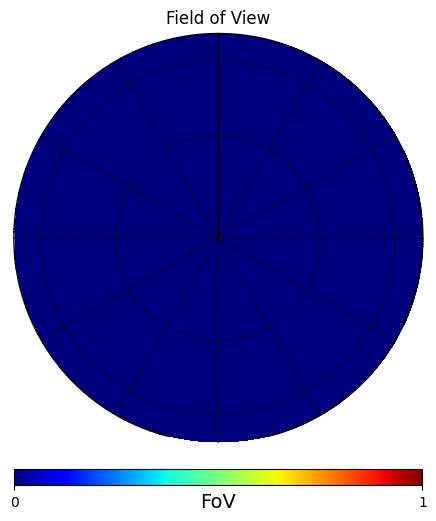

In [59]:
# Show the pixels within the FoV on a new map
show_fov_pixels(pixels, nside)

## Input Options

At this stage, you have the choice of input method—either using a 'global map' or a 'tile'. 

### Option A: 'Tile' Scene
- Directly imports temperatures from a .csv file that you have prepared, which could be one of the provided demo files or your own creation.
- This method is straightforward and efficient for running various scenarios. You can create your .csv manually in Excel or with a more sophisticated script.
- Accommodates any size of square .csv, ranging from single temperature values to large, realistic FoVs.

### Option B: Global Map
- The script determines which pixels fall within the spacecraft's Field of View (FoV) based on the `configuration.json` file.
- Facilitates future investigations into full orbital tours, spacecraft movement, and simulated mission observations using a 'scientifically plausible map' of Enceladus.
- This option involves a more complex workflow and requires the healpix map. There are currently some issues with FoV calculations, and a time component has not yet been incorporated.
- **Note:** The current example map (as of 6/11/23) is for illustrative purposes only and should not be considered accurate.

In [60]:
# OPTION A - FUNCTION
# Import temperatures in 'tile' format - e.g. 10x10 grid FoV prepared separately
# TO DO: Write function & integrate. Print the map. 
def import_temperatures(temp_file_path, fov_deg, altitude):
    # Read the csv file into a NumPy array, handling BOM if present
    try:
        temperatures = np.loadtxt(temp_file_path, delimiter=',', encoding='utf-8-sig')
    except Exception as e:
        print(f"An error occurred while reading the CSV file: {e}")
        return None

    # Flatten the 2D temperatures array into a 1D array
    temperatures = temperatures.flatten()

    # Calculate the physical size of the FoV
    half_fov_rad = np.radians(fov_deg / 2)
    fov_width = 2 * altitude * np.tan(half_fov_rad)

    # Assuming a square FoV, calculate the size of each pixel
    num_pixels_one_side = np.sqrt(temperatures.size)
    pixel_size = fov_width / num_pixels_one_side

    # Round the numbers to three significant figures
    fov_width_rounded = np.round(fov_width, -int(np.floor(np.log10(abs(fov_width))))+2)
    pixel_size_rounded = np.round(pixel_size, -int(np.floor(np.log10(abs(pixel_size))))+2)

    # Display the temperatures as a heatmap
    plt.imshow(temperatures.reshape(-1, int(num_pixels_one_side)), cmap='hot', interpolation='nearest')
    plt.colorbar(label='Temperature (K)')
    plt.title('Tile Map')
    plt.xlabel(f'Pixel size ~ {pixel_size_rounded} m, FoV size ~ {fov_width_rounded} m x {fov_width_rounded} m')
    plt.show()
    
    return temperatures


In [61]:
# OPTION B - FUNCTION
# Extract temperatures from the thermal map based on pixel indices within the FoV
def extract_temperatures(pixels, thermal_map):
    # Initialize an empty list to store temperatures
    temperatures = []
    
    # Loop through each pixel index to get its temperature from the thermal map
    for pixel in pixels:
        temperature = thermal_map[pixel]
        temperatures.append(temperature)
        
    return np.array(temperatures)

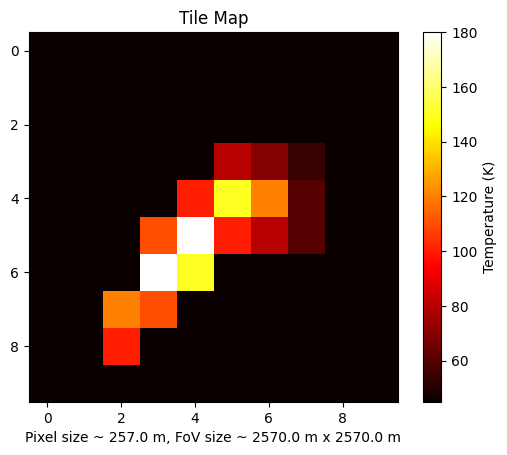

Temperatures within the FoV: [ 45.  45.  45.  45.  45.  45.  45.  45.  45.  45.  45.  45.  45.  45.
  45.  45.  45.  45.  45.  45.  45.  45.  45.  45.  45.  45.  45.  45.
  45.  45.  45.  45.  45.  45.  45.  80.  70.  55.  45.  45.  45.  45.
  45.  45. 100. 150. 120.  60.  45.  45.  45.  45.  45. 110. 180. 100.
  80.  60.  45.  45.  45.  45.  45. 180. 150.  45.  45.  45.  45.  45.
  45.  45. 120. 110.  45.  45.  45.  45.  45.  45.  45.  45. 100.  45.
  45.  45.  45.  45.  45.  45.  45.  45.  45.  45.  45.  45.  45.  45.
  45.  45.]


In [62]:
# Extract temperatures for the identified pixels OR read in a temperature 'tile' file 
# OPTION A
temperatures = import_temperatures("test_tile.csv", fov_deg, altitude)          
# Print out temperatures within FoV
print(f"Temperatures within the FoV: {temperatures}")

# OPTION B
# temperatures = extract_temperatures(pixels, thermal_map)  



### Function: `planck(wavenumber, temperature)`

Calculates blackbody radiance using Planck's Law.

**Equation**:  
$ \text{Radiance} = \frac{2 h \nu^3}{c^2} \frac{1}{e^{\frac{h \nu}{k T}} - 1} $

- **Inputs**: `wavenumber` in $ \text{cm}^{-1} $ , `temperature` in K  
- **Output**: Radiance in nW $ \text{cm}^{-2} \text{str}^{-1} (\text{cm}^{-1})^{-1} $

In [63]:
def planck(wavenumber, temperature):
    # Convert wavenumber to frequency
    wavenumber_si = wavenumber * 100
    frequency = wavenumber_si * c
    
    # Calculate the spectral radiance
    exponent = h * frequency / (k * temperature)
    radiance = (2 * h * frequency**3 / c**2) / (np.exp(exponent) - 1)

    # Convert radiance to units of nW cm^-2 str^-1 cm
    radiance *= 10**13
    
    return radiance

In [64]:
# FUNCTION
# Calculate composite blackbody curve
def composite_blackbody_curve(temperatures, wavenumber_min, wavenumber_max, spectral_resolution):
    # Initialize wavenumber array based on instrument specs
    wavenumbers = np.arange(wavenumber_min, wavenumber_max + spectral_resolution, spectral_resolution)
    
    # Initialize array to store composite radiance values
    composite_radiance = np.zeros_like(wavenumbers)
    
    # Loop through each temperature to calculate its blackbody curve and add it to the composite curve
    for temperature in temperatures:
        radiance = planck(wavenumbers, temperature)
        composite_radiance += radiance / len(temperatures)
    
    return wavenumbers, composite_radiance

In [65]:
# Calculate composite blackbody curve
wavenumbers, composite_radiance = composite_blackbody_curve(temperatures, wavenumber_min, wavenumber_max, spectral_resolution)

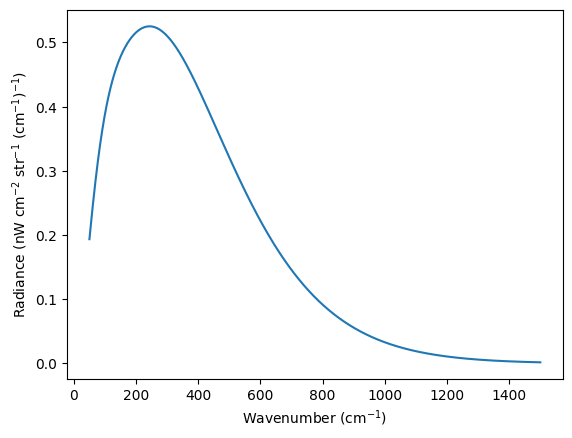

In [66]:
# Plot the composite_radiance array
plt.plot(wavenumbers, composite_radiance)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel(r'Radiance (nW cm$^{-2}$ str$^{-1}$ (cm$^{-1}$)$^{-1}$)')
plt.show()

In [68]:
# Call Bandpass_Sensor_Calculations.py to perform noise calculations NOTE wavenumber_min and wavenumber_max are currently just chosen to function runs (there is a bug)

#WAVENUMBER RANGE chosen to give lambda range of 1-300 microns
wavenumber_min = 3.33E1
wavenumber_max = 1.0E4

#DETECTOR PARAMETERS
Dstar = 1E9                     #This is the broadband D*, assumed constant for the detector. In m Hz^1/2 W^-1
TDI_pixels = 16                 #Assume 16 pixel TDI average, actual number depends on number of filters.
detector_absorption = 0.95      #Sets absorption value for the detector material. This reduces the effective signal level seen by the detector.
det_fnumber = 1.4               #f number of the detector
detector_area = (35.0E-6)**2    #area of detector element in m (Detector element size, INO = 35x35 µm )
telescope_diameter = 0.05       #LTM 5cm telescope  Diviner =4 cm

#ORBITAL PARAMETERS
orbital_altitude = 100.0E3      #Distance to the target body
target_mass = 7.34767309E22     #Mass of the target body in kg
target_radius = 1737E3          #radius of target body in m

#Load the temperature array from the test tile
temperatures = np.loadtxt("test_tile.csv", delimiter=',', encoding='utf-8-sig')

# Flatten the 2D temperatures array into a 1D array
temperature_array = temperatures.flatten()

bandpass_results_array: list = Bandpass_Sensor_Calculations.calculate_snr(wavenumber_min, wavenumber_max, detector_area, telescope_diameter, detector_absorption, det_fnumber, orbital_altitude, target_mass, target_radius, temperature_array, Dstar, TDI_pixels)
    
#Print the results
for bandpass_results in bandpass_results_array:
    print("Bandpass: ", bandpass_results.bandpass_array)
    print("Temperature SNR: ", bandpass_results.temperature_snr)
    print("Emissivity SNR: ", bandpass_results.emissivity_snr)
    print("NEDT: ", bandpass_results.nedt)
    print("NER: ", bandpass_results.ner)
    print("dB/dT: ", bandpass_results.dBdT)
    print("Power at detector: ", bandpass_results.power_detector)

#Print the values sent to the function for verification
print(f"Wavenumber min: {wavenumber_min}")
print(f"Wavenumber max: {wavenumber_max}")
print(f"Detector area: {detector_area}")
print(f"Telescope diameter: {telescope_diameter}")
print(f"Detector absorption: {detector_absorption}")
print(f"Detector f number: {det_fnumber}")
print(f"Orbital altitude: {orbital_altitude}")
print(f"Target mass: {target_mass}")
print(f"Target radius: {target_radius}")
print(f"Temperature array: {temperature_array}")
print(f"Dstar: {Dstar}")
print(f"TDI pixels: {TDI_pixels}")

Calculating SNR for each bandpass: 100%|██████████| 9/9 [01:07<00:00,  7.48s/it]

Bandpass:  [ 7. 15.]
Temperature SNR:  6.36402637897821
Emissivity SNR:  0.06364026378978202
NEDT:  28895809.366767604
NER:  0.015954724439829995
dB/dT:  0.0069025963646681485
Power at detector:  3.0652331418865166e-11
Bandpass:  [15. 25.]
Temperature SNR:  14.545181912373456
Emissivity SNR:  0.14545181912373428
NEDT:  38471.1506482016
NER:  0.015954724439829995
dB/dT:  0.011516448590080566
Power at detector:  7.005686494299819e-11
Bandpass:  [25. 50.]
Temperature SNR:  18.67613372907028
Emissivity SNR:  0.18676133729070427
NEDT:  721.4598749181496
NER:  0.01595472443983
dB/dT:  0.012856201132370267
Power at detector:  8.995359330651017e-11
Bandpass:  [50. 75.]
Temperature SNR:  6.153815256879445
Emissivity SNR:  0.061538152568794545
NEDT:  482.60968020167314
NER:  0.01595472443983
dB/dT:  0.005213513661989782
Power at detector:  2.963984960329837e-11
Bandpass:  [ 75. 100.]
Temperature SNR:  2.663633116416711
Emissivity SNR:  0.026636331164167172
NEDT:  780.5049066398128
NER:  0.015954